<a href="https://colab.research.google.com/github/AinaHerrera/ejerciciosIA/blob/main/Checkpoint_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Esta vez trabajo con el dataset “Psychosocial Dimensions of Student Life” [enlace aqui](https://www.kaggle.com/datasets/mdismielhossenabir/psychosocial-dimensions-of-student-life).

Este reúne información de estudiantes con dimensiones psicosociales y académicas: Age, Gender, AcademicPerformance, TakingNoteInClass, DepressionStatus, FaceChallengesToCompleteAcademicTask, SleepPerDayHours, NumberOfFriends, entre otras.

Mi interés es revisar cómo estos factores del día a día como: sueño, hábitos en clase, retos percibidos y red social se relacionan con el desempeño o el estado emocional.

Este dataset encaja con el proyecto: SenseAI porque me permite observar señales que el proyecto quiere monitorear de forma simple y accionable: hábitos (tomar notas), bienestar (horas de sueño), retos académicos y contexto social. Justamente son los insumos que el dashboard puede mostrar como tarjetas de progreso y que el tutor puede usar para proponer microtareas o recordatorios (por ejemplo, reforzar técnica de estudio cuando suben los desafíos, o sugerir higiene del sueño cuando las horas bajan).

Objetivo del notebook: realizar un EDA visual para identificar patrones entre variables psicosociales/estudiantiles y un resultado relevante (ej., AcademicPerformance o DepressionStatus), y cerrar con insights más una hipótesis concreta para SenseAI: ¿Qué factor conviene vigilar y cómo lo aprovecharía el sistema?.

Este notebook quedará estructurado con breves interpretaciones, un bloque de hallazgos y una conclusión o hipótesis directamente relacionada con SenseAI.

# **Carga y diagnóstico rápido**

Hoy arranco cargando el CSV del dataset Psychosocial Dimensions of Student Life. Antes de dibujar nada, necesito contexto: cuántas filas y columnas tengo, qué tipos de datos vienen, y cuántos valores faltantes aparecen. Con shape, info() y un conteo de nulos me hago una idea clara de la “salud” del archivo.
¿Por qué? Porque cualquier insight que construya más adelante depende de entender qué tan confiable y completo está el material de base.

Qué miro aquí:

El tamaño del dataset (¿es suficientemente grande y variado?).

Tipos de datos por columna (para saber si debo convertir textos a numéricos).

Columnas con muchos nulos (para decidir limpieza focalizada más adelante).

In [8]:
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [9]:
csv_path = "/content/CSE_student_performances.csv"
df = pd.read_csv(csv_path)

print("Archivo:", csv_path)
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nNulos por columna (top 20):")
print(df.isna().sum().sort_values(ascending=False).head(20))
df.head(3)

Archivo: /content/CSE_student_performances.csv
Shape: (99, 10)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   99 non-null     int64  
 1   Gender                                99 non-null     object 
 2   AcademicPerformance                   99 non-null     object 
 3   TakingNoteInClass                     99 non-null     object 
 4   DepressionStatus                      99 non-null     object 
 5   FaceChallangesToCompleteAcademicTask  99 non-null     object 
 6   LikePresentation                      99 non-null     object 
 7   SleepPerDayHours                      99 non-null     int64  
 8   NumberOfFriend                        95 non-null     float64
 9   LikeNewThings                         99 non-null     object 
dtypes: float64(1), int

,Age,Gender,AcademicPerformance,TakingNoteInClass,DepressionStatus,FaceChallangesToCompleteAcademicTask,LikePresentation,SleepPerDayHours,NumberOfFriend,LikeNewThings
0,23,Male,Average,No,Sometimes,Yes,Yes,12,NaN,Yes
1,23,Male,Excellent,Sometimes,Yes,No,Yes,8,80.0,Yes
2,24,Male,Average,No,Sometimes,Sometimes,No,8,10.0,Yes


In [11]:
# Ver exactamente cómo vienen los nombres de columnas
print("Columnas con repr() para ver espacios/caracteres ocultos:")
for i, c in enumerate(df.columns):
    print(i, repr(c))

# ¿Hay algo que parezca Age con variaciones?
candidatas_age = [c for c in df.columns if "age" in c.lower()]
print("\nCandidatas que contienen 'age':", candidatas_age)


Columnas con repr() para ver espacios/caracteres ocultos:
0 'Age '
1 'Gender'
2 'AcademicPerformance'
3 'TakingNoteInClass'
4 'DepressionStatus'
5 'FaceChallangesToCompleteAcademicTask'
6 'LikePresentation'
7 'SleepPerDayHours'
8 'NumberOfFriend'
9 'LikeNewThings'

Candidatas que contienen 'age': ['Age ']


In [12]:
# limpiar encabezados
def clean_header(s):
    return str(s).replace("\ufeff", "").strip()

df = df.rename(columns=lambda c: clean_header(c))

print("Columnas normalizadas:", list(df.columns))


Columnas normalizadas: ['Age', 'Gender', 'AcademicPerformance', 'TakingNoteInClass', 'DepressionStatus', 'FaceChallangesToCompleteAcademicTask', 'LikePresentation', 'SleepPerDayHours', 'NumberOfFriend', 'LikeNewThings']


# **Selección de variables: núcleo y contexto**

Ahora defino mi espina dorsal analítica. Mi objetivo es relacionar dimensiones psicosociales con desempeño o estado emocional, alineado a SenseAI. Por eso separo dos grupos:

Núcleo (df_core): AcademicPerformance (resultado académico) junto con factores candidatos como SleepPerDayHours, TakingNoteInClass, NumberOfFriends, FaceChallengesToCompleteAcademicTask.

Contexto (df_context): variables categóricas para cortes y comparaciones (por ejemplo Gender, y cualquier otra relevante si existe).

No elimino columnas del DataFrame original; solo creo subconjuntos. Así me concentro en lo importante sin perder la posibilidad de ampliar el análisis después.

In [13]:
COL_ACADEMIC = "AcademicPerformance"
COL_SLEEP    = "SleepPerDayHours"
COL_NOTES    = "TakingNoteInClass"
COL_FRIENDS  = "NumberOfFriend"
COL_CHALL    = "FaceChallangesToCompleteAcademicTask"
COL_GENDER   = "Gender"
COL_DEPRESS  = "DepressionStatus"
COL_AGE      = "Age"
COL_LIKEPRES = "LikePresentation"
COL_LIKENEW  = "LikeNewThings"

expected_cols = [COL_ACADEMIC, COL_SLEEP, COL_NOTES, COL_FRIENDS, COL_CHALL,
                 COL_GENDER, COL_DEPRESS, COL_AGE, COL_LIKEPRES, COL_LIKENEW]
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    print("⚠️ Columnas no encontradas (revisa nombres):", missing)

core_cols = [c for c in [COL_ACADEMIC, COL_SLEEP, COL_NOTES, COL_FRIENDS, COL_CHALL, COL_AGE] if c in df.columns]
context_cols = [c for c in [COL_GENDER, COL_DEPRESS, COL_LIKEPRES, COL_LIKENEW] if c in df.columns]

df_core = df[core_cols].copy()
df_context = df[context_cols].copy() if context_cols else None

print("df_core:", df_core.columns.tolist())
print("df_context:", df_context.columns.tolist() if df_context is not None else "—")



df_core: ['AcademicPerformance', 'SleepPerDayHours', 'TakingNoteInClass', 'NumberOfFriend', 'FaceChallangesToCompleteAcademicTask', 'Age']
df_context: ['Gender', 'DepressionStatus', 'LikePresentation', 'LikeNewThings']


In [14]:
# Celda 2.1 — Uniques para definir mapeos de texto→número
cat_cols = [c for c in df_core.columns if df_core[c].dtype == "O"] + \
           ([c for c in (df_context.columns if df_context is not None else []) if df_context[c].dtype == "O"])
cat_cols = list(dict.fromkeys(cat_cols))  # quitar duplicados y preservar orden

for c in cat_cols:
    print(f"\n{c}:")
    print(sorted(df[c].dropna().astype(str).unique()))



AcademicPerformance:
['Average', 'Below average', 'Excellent', 'Good']

TakingNoteInClass:
['No', 'Sometimes', 'Yes']

FaceChallangesToCompleteAcademicTask:
['No', 'Sometimes', 'Yes']

Gender:
['Female', 'Male']

DepressionStatus:
['No', 'Sometimes', 'Yes']

LikePresentation:
['No', 'Yes']

LikeNewThings:
['No', 'Yes']


# **Limpieza mínima y tipificación**

Antes de graficar, dejo limpias y tipadas las columnas del subconjunto: convierto a numérico lo que venga como texto (horas de sueño, desempeño, etc.) y solo elimino filas con nulos en las columnas que cada gráfico necesita. Este enfoque me evita perder observaciones por campos que no usaré en el gráfico actual.
Si encuentro etiquetas inconsistentes (por ejemplo en DepressionStatus), las normalizo (e.g., “Yes/No” → “Sí/No”) para asegurar legibilidad en los gráficos.

In [15]:
# Limpieza con mapeos específicos
def _norm(s):
    return str(s).strip()

df_core_clean = df_core.copy()

# --- 1) Convertir cuantitativas a numérico ---
for c in [COL_SLEEP, COL_FRIENDS, COL_AGE]:
    if c in df_core_clean.columns:
        df_core_clean[c] = pd.to_numeric(df_core_clean[c], errors="coerce")

# --- 2) Mapear categóricas a ordinal/binario coherente con el significado ---

# AcademicPerformance: orden lógico (peor->mejor)
perf_map = {
    "Below average": 2,
    "Average": 3,
    "Good": 4,
    "Excellent": 5
}
if COL_ACADEMIC in df_core_clean.columns:
    vals = df_core_clean[COL_ACADEMIC].astype(str).map(_norm)
    # Si ya fuera numérico no tocamos:
    if df_core_clean[COL_ACADEMIC].dtype == "O":
        mapped = vals.map(perf_map)
        # si alguno no mapea, intentamos convertir a número
        fallback = pd.to_numeric(vals, errors="coerce")
        df_core_clean[COL_ACADEMIC] = mapped.fillna(fallback)

# TakingNoteInClass: intensidad de hábito (No < Sometimes < Yes)
notes_map = {"No": 1, "Sometimes": 2, "Yes": 3}
if COL_NOTES in df_core_clean.columns:
    df_core_clean[COL_NOTES] = df_core_clean[COL_NOTES].map(notes_map)

# FaceChallangesToCompleteAcademicTask: más valor = más desafíos
chall_map = {"No": 1, "Sometimes": 2, "Yes": 3}
if COL_CHALL in df_core_clean.columns:
    df_core_clean[COL_CHALL] = df_core_clean[COL_CHALL].map(chall_map)

# Señales adicionales en df_context
if df_context is not None:
    # DepressionStatus: mayor valor = más síntomas
    if COL_DEPRESS in df_context.columns:
        dep_map = {"No": 0, "Sometimes": 1, "Yes": 2}
        df_context[COL_DEPRESS] = df_context[COL_DEPRESS].map(dep_map)

    # LikePresentation / LikeNewThings: preferencia binaria
    for c in [COL_LIKEPRES, COL_LIKENEW]:
        if c in df_context.columns:
            df_context[c] = df_context[c].map({"No": 0, "Yes": 1})

print("Tipos en df_core_clean:")
print(df_core_clean.dtypes)

print("\nChequeo de mapeos (primeras filas):")
show_cols = [x for x in [COL_ACADEMIC, COL_SLEEP, COL_NOTES, COL_FRIENDS, COL_CHALL, COL_AGE] if x in df_core_clean.columns]
display(df_core_clean[show_cols].head(8))


Tipos en df_core_clean:
AcademicPerformance                       int64
SleepPerDayHours                          int64
TakingNoteInClass                         int64
NumberOfFriend                          float64
FaceChallangesToCompleteAcademicTask      int64
Age                                       int64
dtype: object

Chequeo de mapeos (primeras filas):


,AcademicPerformance,SleepPerDayHours,TakingNoteInClass,NumberOfFriend,FaceChallangesToCompleteAcademicTask,Age
0,3,12,1,NaN,3,23
1,5,8,2,80.0,1,23
2,3,8,1,10.0,2,24
3,4,5,3,15.0,3,20
4,3,5,3,2.0,3,24
5,4,8,2,12.0,1,23
6,4,8,3,7.0,1,21
7,3,8,2,6.0,2,21


# **Gráfico 1: Distribución de desempeño (histograma)**

Empiezo por lo más básico: la distribución de AcademicPerformance. Un histograma me cuenta la historia de la forma: ¿es simétrica, sesgada, con colas largas? Esto me dice si el puntaje típico está concentrado, si hay extremos, y me prepara para interpretar diferencias entre grupos con una base sólida.
Si el proyecto estuviera más centrado en salud mental, haría aquí un gráfico de frecuencias de DepressionStatus como barras para ver proporciones.

Qué busco:

Picos y dispersión (¿la mayoría está en rango medio?).

Señales de outliers (colas inusuales) que requieran precaución.

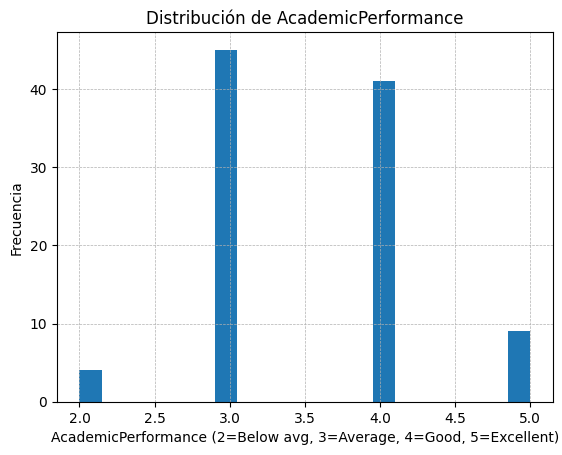

,AcademicPerformance
count,99.000000
mean,3.555556
std,0.717453
min,2.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


In [16]:
# Histograma de AcademicPerformance
subset = df_core_clean[["AcademicPerformance"]].dropna()
if subset.empty:
    print("No hay datos válidos para AcademicPerformance")
else:
    plt.figure()
    subset["AcademicPerformance"].plot(kind="hist", bins=20)
    plt.title("Distribución de AcademicPerformance")
    plt.xlabel("AcademicPerformance (2=Below avg, 3=Average, 4=Good, 5=Excellent)")
    plt.ylabel("Frecuencia")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.show()
    display(subset["AcademicPerformance"].describe())


# **Gráfico 2: Sueño vs desempeño (dispersión)**

Ahora contrasto una hipótesis muy intuitiva: ¿Más horas de sueño (SleepPerDayHours) se asocian con mejor AcademicPerformance? Para eso uso un scatter. Visualmente puedo detectar tendencia (ascendente/descendente) y posibles no linealidades.
Acompaño la figura con el valor de correlación de Pearson: no es una prueba causal, pero me da una magnitud y dirección de la asociación.

Qué busco:

Tendencia general (¿los puntos suben a medida que crece el sueño?).

Dispersión: ¿la relación es fuerte, moderada o débil?

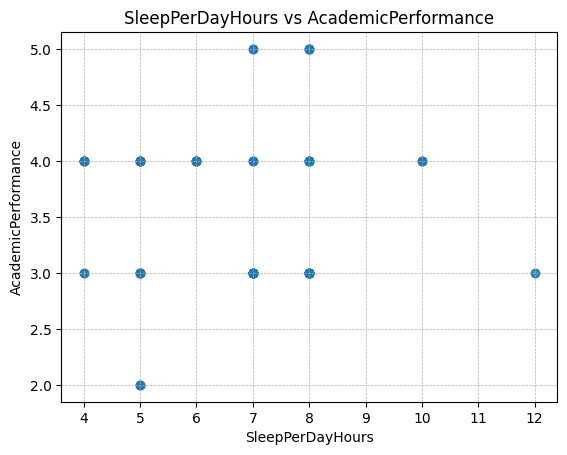

Correlación (Pearson): r = 0.045


In [17]:
# Sueño vs desempeño (scatter + correlación)
cols_needed = ["SleepPerDayHours", "AcademicPerformance"]
subset = df_core_clean[cols_needed].dropna()
if subset.empty:
    print("Datos insuficientes para", cols_needed)
else:
    plt.figure()
    plt.scatter(subset["SleepPerDayHours"], subset["AcademicPerformance"], alpha=0.65)
    plt.title("SleepPerDayHours vs AcademicPerformance")
    plt.xlabel("SleepPerDayHours")
    plt.ylabel("AcademicPerformance")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.show()

    r = subset.corr().loc["SleepPerDayHours", "AcademicPerformance"]
    print(f"Correlación (Pearson): r = {r:.3f}")


# **Gráfico 3: Hábitos/retos y desempeño (boxplot)**

Quiero ver si hábitos específicos o desafíos académicos se reflejan en el desempeño. Un boxplot de AcademicPerformance por TakingNoteInClass (si es categórica) o por niveles de FaceChallengesToCompleteAcademicTask me permite comparar medianas y variabilidad entre grupos.
Este gráfico aporta una lectura “por segmentos” que el scatter no ofrece: si tomar notas o enfrentar más desafíos distingue claramente los resultados.

Qué busco:

Diferencias de mediana entre categorías.

Grupos con mayor dispersión (potencialmente más inestables).

<Figure size 640x480 with 0 Axes>

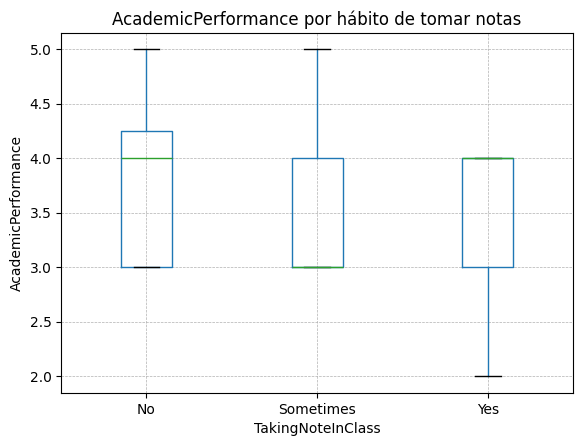

In [18]:
# Boxplot por TakingNoteInClass (1–3) o por tramos de FaceChallangesToCompleteAcademicTask (1–3)
if "TakingNoteInClass" in df_core_clean.columns and df_core_clean["TakingNoteInClass"].notna().any():
    sub = df_core_clean[["AcademicPerformance", "TakingNoteInClass"]].dropna()
    if sub.empty:
        print("Datos insuficientes para boxplot por TakingNoteInClass.")
    else:
        labels = {1:"No", 2:"Sometimes", 3:"Yes"}
        sub["NotesGrp"] = sub["TakingNoteInClass"].map(labels).astype("category")
        plt.figure()
        sub.boxplot(column="AcademicPerformance", by="NotesGrp")
        plt.title("AcademicPerformance por hábito de tomar notas")
        plt.suptitle("")
        plt.xlabel("TakingNoteInClass")
        plt.ylabel("AcademicPerformance")
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.show()
else:
    print("No se usó TakingNoteInClass; probando por niveles de desafíos…")
    if "FaceChallangesToCompleteAcademicTask" in df_core_clean.columns:
        sub = df_core_clean[["AcademicPerformance","FaceChallangesToCompleteAcademicTask"]].dropna()
        if sub.empty:
            print("Datos insuficientes para boxplot por desafíos.")
        else:
            labels = {1:"No", 2:"Sometimes", 3:"Yes"}
            sub["ChallengesGrp"] = sub["FaceChallangesToCompleteAcademicTask"].map(labels).astype("category")
            plt.figure()
            sub.boxplot(column="AcademicPerformance", by="ChallengesGrp")
            plt.title("AcademicPerformance por nivel de desafíos")
            plt.suptitle("")
            plt.xlabel("FaceChallangesToCompleteAcademicTask")
            plt.ylabel("AcademicPerformance")
            plt.grid(True, linestyle="--", linewidth=0.5)
            plt.show()


# **Gráfico 4: Panorama de correlaciones (heatmap numérico)**

Construyo un mapa de correlaciones con variables numéricas clave (desempeño, sueño, número de amigos, frecuencia de presentaciones, etc.). El heatmap me da una vista de “radar” para detectar pares prometedores que merecen atención adicional.
No me quedo con la estética: anoto los 1–2 coeficientes con mayor |r| para referirme a ellos en hallazgos.

Qué busco:

Variables con asociación más marcada con AcademicPerformance.

Sorpresas (factores psicosociales con señales más altas de lo esperado).

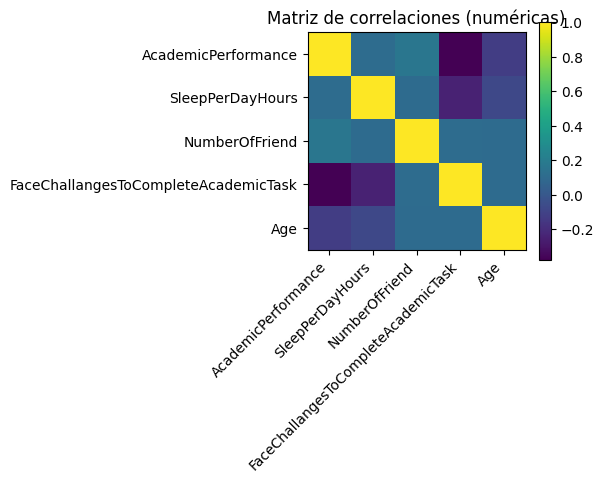

Correlaciones con AcademicPerformance (ordenadas):


,AcademicPerformance
AcademicPerformance,1.000000
NumberOfFriend,0.163096
SleepPerDayHours,0.110756
Age,-0.126220
FaceChallangesToCompleteAcademicTask,-0.374703


In [19]:
# Heatmap de correlaciones
num_candidates = ["AcademicPerformance", "SleepPerDayHours", "NumberOfFriend", "FaceChallangesToCompleteAcademicTask", "Age"]
num_cols = [c for c in num_candidates if c in df_core_clean.columns]
num_df = df_core_clean[num_cols].apply(pd.to_numeric, errors="coerce").dropna()

if num_df.shape[1] < 2 or num_df.empty:
    print("Datos insuficientes para heatmap.")
else:
    corr_mat = num_df.corr()
    plt.figure(figsize=(6,5))
    plt.imshow(corr_mat, interpolation='nearest')
    plt.title("Matriz de correlaciones (numéricas)")
    plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
    plt.yticks(range(len(num_cols)), num_cols)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    if "AcademicPerformance" in corr_mat.columns:
        print("Correlaciones con AcademicPerformance (ordenadas):")
        display(corr_mat[["AcademicPerformance"]].sort_values(by="AcademicPerformance", ascending=False))


# **Gráfico 5: Rendimiento por grupo (barras por categoría)**

Complemento con un gráfico de barras de media de AcademicPerformance por Gender (o alguna otra categoría disponible y relevante). Esto me sirve para detectar brechas o confirmar similitudes entre grupos.
Es un corte simple, pero valioso para el tablero de SenseAI si llega a mostrar “comparativos” básicos.

Qué busco:

Diferencias claras o ausencia de brechas.

Tamaño de muestra por categoría

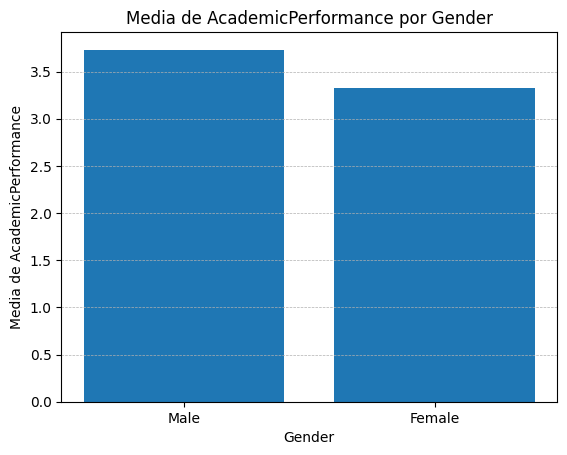

,Gender,AcademicPerformance
1,Male,3.732143
0,Female,3.325581


In [20]:
# Media de AcademicPerformance por Gender
if df_context is not None and "Gender" in df_context.columns:
    tmp = pd.concat([df_core_clean[["AcademicPerformance"]], df_context[["Gender"]]], axis=1).dropna()
    if tmp.empty:
        print("Datos insuficientes para barras por Gender.")
    else:
        grp = tmp.groupby("Gender", as_index=False)["AcademicPerformance"].mean().sort_values("AcademicPerformance", ascending=False)
        plt.figure()
        plt.bar(grp["Gender"].astype(str), grp["AcademicPerformance"].values)
        plt.title("Media de AcademicPerformance por Gender")
        plt.xlabel("Gender")
        plt.ylabel("Media de AcademicPerformance")
        plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
        plt.show()
        display(grp)
else:
    print("No está disponible la columna Gender en df_context.")


# **Gráfico 6: Desafíos académicos en tramos**

Si FaceChallengesToCompleteAcademicTask es numérica o ordinal, la agrupo en tramos (bajo/medio/alto) y grafico la media de AcademicPerformance por tramo. Así traduzco un continuo a una lectura más accionable: ¿a mayor reto reportado, menor desempeño promedio?
Esta figura es útil para SenseAI porque se parece a una regla: “si el reto sube, acciona recordatorios/microtareas”.

Qué busco:

Patrón monótono (¿la media cae cuando el reto sube?).

Señales de umbrales (¿hay un punto donde el desempeño se desploma?).

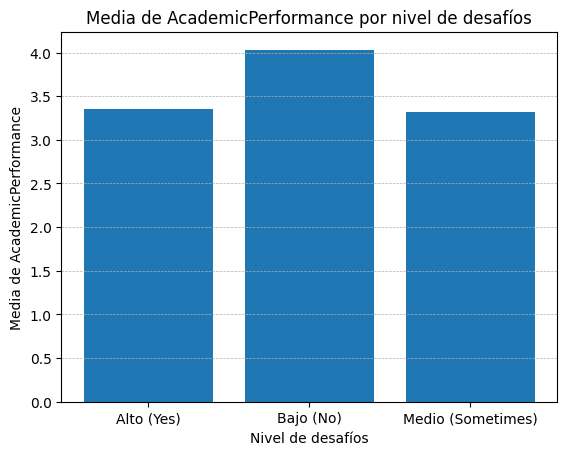

,ChallengesGrp,AcademicPerformance
0,Alto (Yes),3.351351
1,Bajo (No),4.032258
2,Medio (Sometimes),3.322581


In [23]:
# Media de desempeño por nivel de desafíos
col_y = "AcademicPerformance"
col_x = "FaceChallangesToCompleteAcademicTask"

if col_x in df_core_clean.columns and col_y in df_core_clean.columns:
    tmp = df_core_clean[[col_y, col_x]].dropna().copy()
    if tmp.empty:
        print("Datos insuficientes para tramos de desafíos.")
    else:
        uniq = sorted(tmp[col_x].dropna().unique())
        # Caso A: ya es ordinal 1–3 (No=1, Sometimes=2, Yes=3) → no usamos qcut
        if set(uniq) <= {1, 2, 3} and len(set(uniq)) >= 2:
            label_map = {1: "Bajo (No)", 2: "Medio (Sometimes)", 3: "Alto (Yes)"}
            tmp["ChallengesGrp"] = tmp[col_x].map(label_map)
        else:
            # Caso B: continuo → qcut con ajuste de labels al nº de bins efectivos
            q = 3
            tmp["ChallengesGrp"] = pd.qcut(
                tmp[col_x],
                q=q,
                duplicates="drop"  # si hay empates en cuantiles, reduce bins
            )
            # Ajustar labels al nº de bins reales
            bins = tmp["ChallengesGrp"].cat.categories
            k = len(bins)  # nº real de bins
            lbls = ["Bajo", "Medio", "Alto"][:k]
            tmp["ChallengesGrp"] = pd.Categorical(tmp["ChallengesGrp"], categories=bins, ordered=True)
            tmp["ChallengesGrp"] = tmp["ChallengesGrp"].cat.rename_categories(lbls)

        grp = tmp.groupby("ChallengesGrp", as_index=False)[col_y].mean()

        plt.figure()
        plt.bar(grp["ChallengesGrp"].astype(str), grp[col_y].values)
        plt.title(f"Media de {col_y} por nivel de desafíos")
        plt.xlabel("Nivel de desafíos")
        plt.ylabel(f"Media de {col_y}")
        plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
        plt.show()
        display(grp)
else:
    print("No están disponibles las columnas necesarias para este gráfico.")


# **Hallazgos**

Aquí sintetizo 4–6 hallazgos en bullets, cada uno respaldado por al menos uno de los gráficos previos. Me enfoco en patrones consistentes y anoto anomalías si las veo (valores imposibles, colas raras, categorías diminutas).

Ejemplos que espero ver (ilustrativos):

Asociación positiva moderada entre sueño y desempeño.

Estudiantes que toman notas tienden a mostrar mejores medianas.

A mayor reto académico reportado, menor media de desempeño (tramos).

Correlaciones más altas de lo previsto con algún factor psicosocial específico.

In [24]:
# Hallazgos (borrador)
findings = []

# Distribución de desempeño
desc = df_core_clean["AcademicPerformance"].dropna().describe() if "AcademicPerformance" in df_core_clean.columns else None
if desc is not None and not desc.empty:
    findings.append(f"- AcademicPerformance: media {desc['mean']:.2f}, mediana {desc['50%']:.2f}, min {desc['min']:.2f}, max {desc['max']:.2f}.")

# Correlación sueño–desempeño
if set(["SleepPerDayHours","AcademicPerformance"]).issubset(df_core_clean.columns):
    sub = df_core_clean[["SleepPerDayHours","AcademicPerformance"]].dropna()
    if not sub.empty:
        r = sub.corr().iloc[0,1]
        trend = "positiva" if r > 0.10 else ("negativa" if r < -0.10 else "débil")
        findings.append(f"- Sueño vs desempeño: r={r:.2f} ({trend}).")

# Notas en clase (si mapeada 1–3)
if set(["TakingNoteInClass","AcademicPerformance"]).issubset(df_core_clean.columns):
    g = df_core_clean[["TakingNoteInClass","AcademicPerformance"]].dropna()
    if not g.empty and set(g["TakingNoteInClass"].unique()) <= {1,2,3}:
        means = g.groupby("TakingNoteInClass")["AcademicPerformance"].mean().to_dict()
        findings.append(f"- Notas en clase (1=No,2=Sometimes,3=Yes) → medias: {means}.")

# Desafíos y desempeño
if set(["FaceChallangesToCompleteAcademicTask","AcademicPerformance"]).issubset(df_core_clean.columns):
    h = df_core_clean[["FaceChallangesToCompleteAcademicTask","AcademicPerformance"]].dropna()
    if not h.empty:
        r2 = h.corr().iloc[0,1]
        sign = "menor" if r2 < -0.10 else ("mayor" if r2 > 0.10 else "similar")
        findings.append(f"- Más desafíos reportados tienden a asociarse con {sign} desempeño (r={r2:.2f}).")

# Amigos y desempeño
if set(["NumberOfFriend","AcademicPerformance"]).issubset(df_core_clean.columns):
    k = df_core_clean[["NumberOfFriend","AcademicPerformance"]].dropna()
    if not k.empty:
        r3 = k.corr().iloc[0,1]
        trend3 = "positiva" if r3 > 0.10 else ("negativa" if r3 < -0.10 else "débil")
        findings.append(f"- Nº de amigos vs desempeño: r={r3:.2f} ({trend3}).")

print("Hallazgos (borrador):")
print("\n".join(findings) if findings else "(sin hallazgos generados automáticamente)")


Hallazgos (borrador):
- AcademicPerformance: media 3.56, mediana 4.00, min 2.00, max 5.00.
- Sueño vs desempeño: r=0.05 (débil).
- Notas en clase (1=No,2=Sometimes,3=Yes) → medias: {1: 3.8333333333333335, 2: 3.6538461538461537, 3: 3.459016393442623}.
- Más desafíos reportados tienden a asociarse con menor desempeño (r=-0.38).
- Nº de amigos vs desempeño: r=0.16 (positiva).


# **Conclusión e hipótesis para SenseAI**

Cierro con una hipótesis concreta que el módulo dashboard/tutor de SenseAI pueda usar. Por ejemplo: “Horas de sueño y hábito de tomar notas aparecen como señales útiles; cuando el sistema detecte baja de sueño o ausencia de notas, debe recomendar microtareas y recordatorios suaves. Si suben los desafíos académicos, SenseAI prioriza rutinas breves (p. ej., técnicas de estudio de 10–15 min) y sugiere contactar soporte si el patrón persiste”.
El objetivo es traducir datos a una acción clara: qué mostrar en tarjetas del tablero y qué sugerir automáticamente.

Para análisis futuros, anoto dos ampliaciones naturales:

probar otras variables objetivo (p. ej., DepressionStatus con proporciones por bins de sueño), y explorar interacciones simples (sueño × tomar notas).

In [25]:
# Conclusión/Hipótesis (relación con SenseAI)
def fmt(x):
    return "—" if x is None or (isinstance(x, float) and np.isnan(x)) else f"{x:.2f}"

r_sleep = np.nan
sub = df_core_clean[["SleepPerDayHours","AcademicPerformance"]].dropna() \
      if set(["SleepPerDayHours","AcademicPerformance"]).issubset(df_core_clean.columns) else None
if sub is not None and not sub.empty:
    r_sleep = sub.corr().iloc[0,1]

text = f"""
Conclusión/Hipótesis (borrador):
- Se observa r={fmt(r_sleep)} entre horas de sueño y desempeño; conviene monitorear SleepPerDayHours en el tablero.
- Hábitos (TakingNoteInClass) y desafíos (FaceChallangesToCompleteAcademicTask) muestran patrones que diferencian el rendimiento.

Para SenseAI:
- Si bajan las horas de sueño o suben los desafíos, el tutor sugiere microtareas de 10–15 min y recordatorios de higiene del sueño.
- Si TakingNoteInClass es bajo, recomendar técnicas de notas (Cornell, bullet points) y medir adopción la semana siguiente.
"""
print(text.strip())


Conclusión/Hipótesis (borrador):
- Se observa r=0.05 entre horas de sueño y desempeño; conviene monitorear SleepPerDayHours en el tablero.
- Hábitos (TakingNoteInClass) y desafíos (FaceChallangesToCompleteAcademicTask) muestran patrones que diferencian el rendimiento.

Para SenseAI:
- Si bajan las horas de sueño o suben los desafíos, el tutor sugiere microtareas de 10–15 min y recordatorios de higiene del sueño.
- Si TakingNoteInClass es bajo, recomendar técnicas de notas (Cornell, bullet points) y medir adopción la semana siguiente.


# **Exportación de reporte**

In [27]:
# Guardar reporte
from pathlib import Path

REPORT_PATH = Path("/content/EDA_Psychosocial_SenseAI_Resumen.txt")
content = []
content.append("EDA — Psychosocial Dimensions of Student Life (SenseAI)")
content.append(f"Figuras generadas en el cuaderno. Resumen de hallazgos:")
content.extend(findings if 'findings' in globals() and findings else ["(sin hallazgos automáticos)"])

with open(REPORT_PATH, "w", encoding="utf-8") as f:
    f.write("\n".join(content))

print(f"📄 Reporte guardado en: {REPORT_PATH}")

📄 Reporte guardado en: /content/EDA_Psychosocial_SenseAI_Resumen.txt
